<a href="https://colab.research.google.com/github/aaronmj7/Assignment-3-LLM/blob/main/Assignment_3_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 3 - Large language models**

In [1]:
# Install necessary libraries
!pip install datasets evaluate transformers[sentencepiece]
# Clear the output
from IPython.display import clear_output
clear_output()

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification, create_optimizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [3]:
sns.set_theme()

## Load Data

In [4]:
# Load dataset
raw_ds = load_dataset("OxAISH-AL-LLM/wiki_toxic")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/127656 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/31915 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/63978 [00:00<?, ? examples/s]

Generating balanced_train split:   0%|          | 0/25868 [00:00<?, ? examples/s]

In [5]:
raw_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 25868
    })
})

In [6]:
raw_ds["train"].features

{'id': Value(dtype='string', id=None),
 'comment_text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['non', 'tox'], id=None)}

In [7]:
label_names = raw_ds["train"].features['label'].names
label_names

['non', 'tox']

In [8]:
raw_ds["train"][0]

{'id': '794c30aff0931384',
 'comment_text': "And that's not a personal attack^^ ?",
 'label': 0}

In [9]:
ds = raw_ds["balanced_train"]
ds

Dataset({
    features: ['id', 'comment_text', 'label'],
    num_rows: 25868
})

In [10]:
ds[:5]

{'id': ['653b15d1deea659e',
  '57c5f0e88e9e5219',
  'e78a6eb06dbddd9a',
  '435008cc6f750098',
  '2c60f0fc97d86718'],
 'comment_text': ['"\nNot if I can help it. Mudslide is more like it....127 "',
  'Footnotes/references\nOk. I have no objection',
  '.\nI am a loser and I need your help to get a life',
  '"\nI think I\'ve decided that I have no strong opinion. As long as the style doesn\'t have any of the old problems, it doesn\'t matter to me if it\'s substed or transcluded. Just no metadata, no hide/show, and no junk links. -  (conspire | past ops) "',
  'Quite frankly nothing is helping due to his arrogance and truculence. He keeps getting called a dick as he is acting like one, over and over. In my view that makes him one. Thank you for posting my comment over to the IB. Incidentally, what makes you think a block will cure anything?'],
 'label': [0, 0, 0, 0, 1]}

## EDA

In [11]:
# Convert dataset to DataFrame
ds.set_format("pandas")
df = ds[:]

# Reset dataset format
ds.reset_format()

# Display first few rows
df.head()

,id,comment_text,label
0,653b15d1deea659e,"""\nNot if I can help it. Mudslide is more like...",0
1,57c5f0e88e9e5219,Footnotes/references\nOk. I have no objection,0
2,e78a6eb06dbddd9a,.\nI am a loser and I need your help to get a ...,0
3,435008cc6f750098,"""\nI think I've decided that I have no strong ...",0
4,2c60f0fc97d86718,Quite frankly nothing is helping due to his ar...,1


In [12]:
try:
    df.drop(columns=['id'], inplace=True)
except KeyError:
    pass
df.head()

,comment_text,label
0,"""\nNot if I can help it. Mudslide is more like...",0
1,Footnotes/references\nOk. I have no objection,0
2,.\nI am a loser and I need your help to get a ...,0
3,"""\nI think I've decided that I have no strong ...",0
4,Quite frankly nothing is helping due to his ar...,1


label
0    12934
1    12934
Name: count, dtype: int64


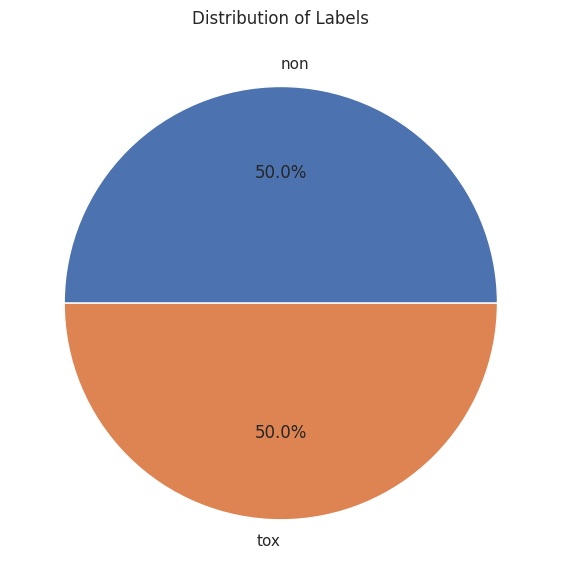

In [13]:
# Calculate the proportions of each label
label_counts = df['label'].value_counts()
sizes = label_counts.values.tolist()
print(label_counts)

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=label_names, autopct='%1.1f%%')
plt.title('Distribution of Labels')
plt.tight_layout()
plt.show()

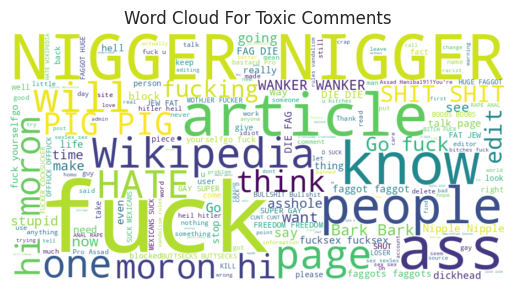

In [14]:
from wordcloud import WordCloud

toxic_comments = ''.join(df[df['label'] == 1]['comment_text'])
toxic_words = WordCloud(width = 900, height = 450, background_color = "white").generate(toxic_comments)
plt.imshow(toxic_words, interpolation = 'bilinear')
plt.axis("off")
plt.title("Word Cloud For Toxic Comments")
plt.show()

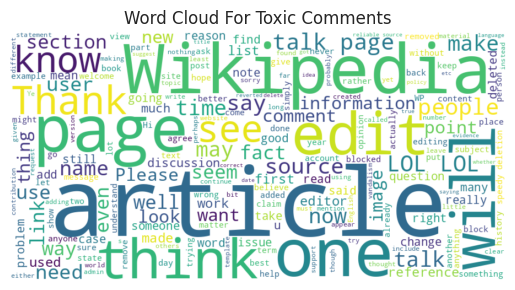

In [15]:
non_toxic_comments = ''.join(df[df['label'] == 0]['comment_text'])
non_toxic_words = WordCloud(width = 900, height = 450, background_color = "white").generate(non_toxic_comments)
plt.imshow(non_toxic_words, interpolation = 'bilinear')
plt.axis("off")
plt.title("Word Cloud For Toxic Comments")
plt.show()

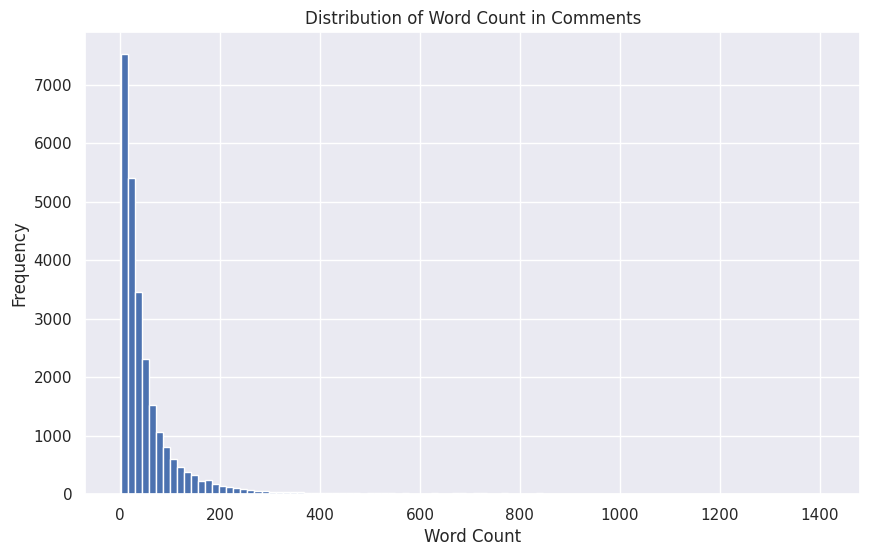

In [16]:
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# Plotting the distribution
plt.figure(figsize=(10,6))
df['word_count'].hist(bins=100)
plt.title('Distribution of Word Count in Comments')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [17]:
df['word_count'].describe()

,word_count
count,25868.000000
mean,60.085666
std,101.457404
min,1.000000
25%,13.000000
50%,29.000000
75%,63.000000
max,1411.000000


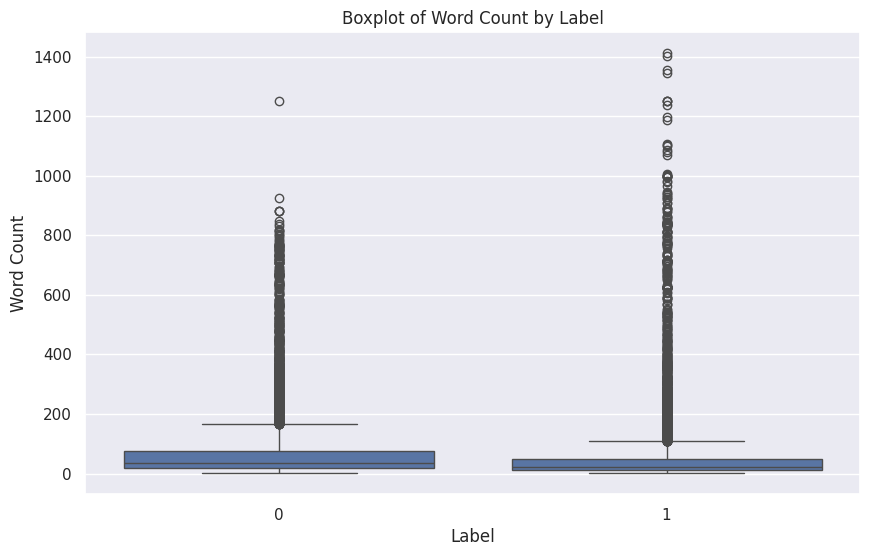

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='word_count', data=df)
plt.title('Boxplot of Word Count by Label')
plt.xlabel('Label')
plt.ylabel('Word Count')
plt.show()

## Pre-processing

In [19]:
# Set model checkpoint
model_checkpoint = "distilbert-base-uncased"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
# Check if it is a fast tokenizer
tokenizer.is_fast

True

In [21]:
tokenizer.model_max_length

512

In order to run our experiments on GPUs found on Google Colab, we’ll pick something a bit smaller.

In [22]:
# Tokenize a comment
inputs = tokenizer(ds[0]['comment_text'], truncation=True, max_length=128)
inputs

{'input_ids': [101, 1000, 2025, 2065, 1045, 2064, 2393, 2009, 1012, 8494, 14540, 5178, 2003, 2062, 2066, 2009, 1012, 1012, 1012, 1012, 13029, 1000, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [23]:
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"]))
print(ds[0]['comment_text'])

['[CLS]', '"', 'not', 'if', 'i', 'can', 'help', 'it', '.', 'mud', '##sl', '##ide', 'is', 'more', 'like', 'it', '.', '.', '.', '.', '127', '"', '[SEP]']
"
Not if I can help it. Mudslide is more like it....127 "


In [24]:
ds = ds.train_test_split(test_size=0.2, seed=73)
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 20694
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 5174
    })
})

In [25]:
# Define a function to tokenize
def tokenize(ex):
    return tokenizer(ex["comment_text"], truncation=True, max_length=128)

In [26]:
tokenized_ds = ds.map(tokenize, batched=True)
tokenized_ds

Map:   0%|          | 0/20694 [00:00<?, ? examples/s]

Map:   0%|          | 0/5174 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 20694
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5174
    })
})

In [27]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [28]:
samples = tokenized_ds["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["id", "comment_text"]}
[len(x) for x in samples["input_ids"]]

[12, 29, 11, 38, 125, 128, 128, 80]

In [29]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': TensorShape([8, 128]),
 'attention_mask': TensorShape([8, 128]),
 'labels': TensorShape([8])}

In [30]:
train_dataset = tokenized_ds["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=16,
)

valid_dataset = tokenized_ds["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=16,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [61]:
valid_dataset.element_spec

({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

## Model

In [49]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [50]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_59 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
num_epochs = 3
num_train_steps = len(train_dataset) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr=1e-6,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [52]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=num_epochs,
                    )

Epoch 1/3
1294/1294 [==============================] - 332s 250ms/step - loss: 0.3732 - accuracy: 0.8601 - val_loss: 0.2196 - val_accuracy: 0.9206
Epoch 2/3
1294/1294 [==============================] - 322s 249ms/step - loss: 0.2131 - accuracy: 0.9211 - val_loss: 0.1984 - val_accuracy: 0.9283
Epoch 3/3
1294/1294 [==============================] - 322s 249ms/step - loss: 0.1985 - accuracy: 0.9255 - val_loss: 0.1947 - val_accuracy: 0.9285


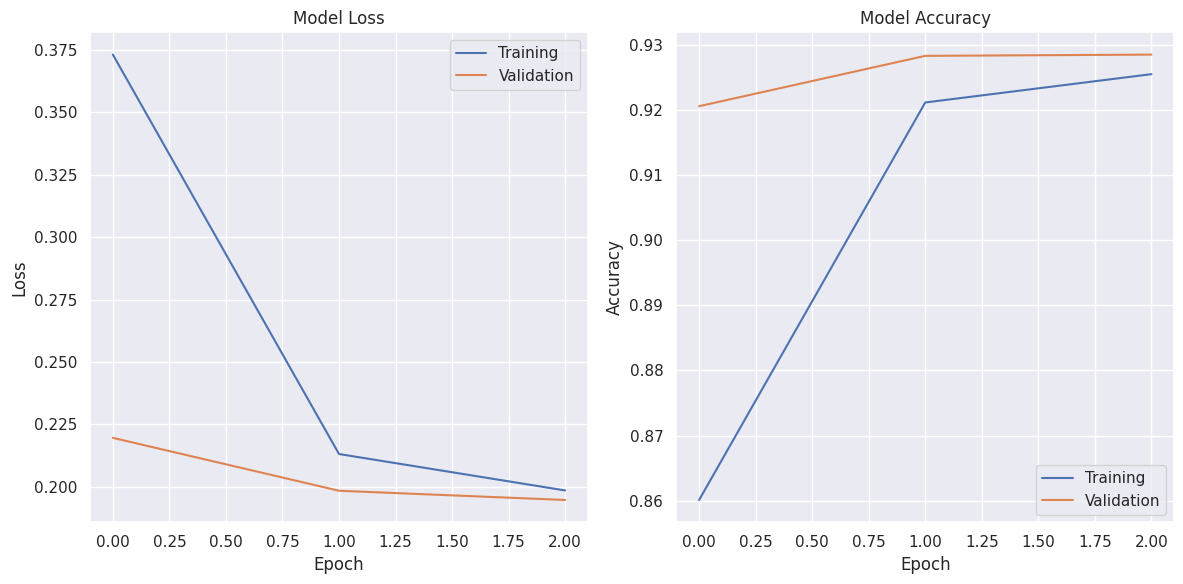

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

# Plot training and validation accuracy
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()


In [59]:
Pred = model.predict(valid_dataset)
Pred = np.argmax(Pred.logits, axis=1)


324/324 [==============================] - 27s 76ms/step
